# PANEL 6

**Input:** 
1. Basecalled and aligned bam files including pseU calls of HEK293T and oligo samples
2. Basecalled and aligned bam files including m6A calls for 18S rRNA and blood samples (patient, healthy controls and IVT) 

**Output:** 
1. FIGURES 6E and 6G
2. SUPPLEMENTARY: Modification probability plots for pseU calling of vectors, oligos and known gene site
2. FIGURES 7F and 7G

## Load packages

In [1]:
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pylab as plt
import pyranges as pr

## 1. Extract U>C mismatch percentages and modification calls from dorado for regions of interest

In [ ]:
# Extract U>C mismatch percentages
def extract_modifcation_infos(i, out_df_mod, mod_pos, threshold, key = ('T', 0, 17802)):
    # Check if modification present
    if key not in i.modified_bases.keys():
        return(out_df_mod)
    # Extract modification information
    mod_obj = i.modified_bases[key]
    mod_info = [m for m in mod_obj if m[0] == mod_pos[0][0]]
    # If no modification detected
    if len(mod_info) == 0:
        mod_info = [(mod_pos[0][0],0)]
        # Set modification probability to 0
        modprob = 0
        #print(mod_pos)
        # Check if mismatch was found (represented by reference base in small letters)
        if mod_pos[0][2] in ["t", "a", "g", "c"]:
            # Extract mismatch base
            called_base = i.query_sequence[mod_pos[0][0]]
            # If mismatch base == C, count for mismtach_C label
            if called_base == "C":
                out_df_mod["mismatch_C"] += 1
            else:
                # If mismatch base == A or U or G, count for mismtach_AUG label
                out_df_mod["mismatch_AUG"] += 1
        # If mod pos is empty -> deletion
        elif mod_pos[0][0] == None:
            out_df_mod["deletion"] += 1
        else:
            out_df_mod["canonical"] += 1
    # If modification present
    else:
        # Reformate probability
        modprob = (mod_info[0][1]+1)/256
        # Check if modification passes threshold (p = 0.98)
        if modprob < threshold:
            out_df_mod["fail"] += 1
        else:
            out_df_mod["modified"] += 1
    return(out_df_mod)

# FUnction to extract the modification probabilites from DORADO
def get_mod_probs(i, mod_pos, key = ('T', 0, 17802)):
    modprob = None
    if key in i.modified_bases.keys():
        mod_obj = i.modified_bases[key]
        mod_info = [m for m in mod_obj if m[0] == mod_pos[0][0]]
        if len(mod_info) > 0:
            modprob = (mod_info[0][1]+1)/256
    return(modprob)
 
def extract_dorado_calls_mer(bamFile, sample, threshold = 0.98, key = ('T', 0, 17802)):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    tmp_EGFP_out = pd.DataFrame()
    tmp_mCherry_out = pd.DataFrame()
    thresholds_hist1 = []
    thresholds_hist2 = []

    for pileupcolumn in samfile.pileup("EGFP", start = 114, end = 115, truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold, key)
                thresholds_hist1.append(get_mod_probs(i, mod_pos, key))

        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_EGFP_out = pd.concat([tmp, tmp_EGFP_out], axis = 0)
    tmp_EGFP_out["Ref"] = "EGFP"
    thresholds_hist_df1 = pd.DataFrame({"Ref" :"EGFP", "Contig" : sample, "ref_pos" : 114, "thresholds" : thresholds_hist1})
    if (key[0] == "C"):
        out_name = "thresholds_EGFP_" + sample + "_Ccalls.csv"
    else:
        out_name = "thresholds_EGFP_" + sample + "_Ucalls.csv"

    thresholds_hist_df1.to_csv(out_name, index =False)
    
    
    for pileupcolumn in samfile.pileup("mCherry", start = 564, end = 565, truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold, key)
                thresholds_hist2.append(get_mod_probs(i, mod_pos, key))

        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_mCherry_out = pd.concat([tmp, tmp_mCherry_out], axis = 0)
    tmp_mCherry_out["Ref"] = "mCherry"
    thresholds_hist_df2 = pd.DataFrame({"Ref" :"mCherry", "Contig" : sample, "ref_pos" : 564, "thresholds" : thresholds_hist2})
    if (key[0] == "C"):
        out_name = "thresholds_mCherry_" + sample + "_Ccalls.csv"
    else: 
        out_name = "thresholds_mCherry_" + sample + "_Ucalls.csv"
    thresholds_hist_df2.to_csv(out_name, index =False)
  
    
    out_df = pd.concat([tmp_mCherry_out.reset_index(), tmp_EGFP_out.reset_index()], axis = 0)
    out_df["Contig"] = sample
    out_df.columns = ["condition", "Nreads", "ref_pos", "Ref", "Contig"]
    return(out_df)

def extract_dorado_calls_oligos_10mer(bamFile, sample, refs, threshold = 0.98, key = ('T', 0, 17802)):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    tmp_1_out = pd.DataFrame()
    tmp_2_out = pd.DataFrame()
    thresholds_hist1 = []
    thresholds_hist2 = []

    for pileupcolumn in samfile.pileup(sample, start = 73, end = 74, truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold, key)
                thresholds_hist1.append(get_mod_probs(i, mod_pos, key))

        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_1_out = pd.concat([tmp, tmp_1_out], axis = 0)
    tmp_1_out["Ref"] = refs[0]
    thresholds_hist_df1 = pd.DataFrame({"Ref" : refs[0], "Contig" : sample, "ref_pos" : 73, "thresholds" : thresholds_hist1})
    if (key[0] == "C"):

        out_name = "thresholds_" + refs[0] + sample + "_Ccalls.csv"
    else:
        out_name = "thresholds_" + refs[0] + sample + "_Ucalls.csv"

    thresholds_hist_df1.to_csv(out_name, index =False)
    
    for pileupcolumn in samfile.pileup(sample, start = 113, end = 114, truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold, key)
                thresholds_hist2.append(get_mod_probs(i, mod_pos, key))

        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_2_out = pd.concat([tmp, tmp_2_out], axis = 0)
    tmp_2_out["Ref"] = refs[1]
    thresholds_hist_df2 = pd.DataFrame({"Ref" : refs[1], "Contig" : sample, "ref_pos" : 113, "thresholds" : thresholds_hist2})
    if (key[0] == "C"):

        out_name2 = "thresholds_" + refs[1] + sample + "_Ccalls.csv"
    else: 
        out_name2 = "thresholds_" + refs[1] + sample + "_Ucalls.csv"
    thresholds_hist_df2.to_csv(out_name2, index =False)
    
    
    out_df = pd.concat([tmp_1_out.reset_index(), tmp_2_out.reset_index()], axis = 0)
    out_df["Contig"] = sample
    out_df.columns = ["condition", "Nreads", "ref_pos", "Ref", "Contig"]
    
    
    return(out_df)

 

### 1. HEK293T Samples A and B

In [ ]:
# Dorado basecalled samples using default settings for pseU calling
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/A_vector_004.0.7.2.vector.bam"
sample = "Sample A"
Sample_A_mpileup = extract_dorado_calls_mer(bamFile, sample)

bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/B_vector_004.0.7.2.vector.bam"
sample = "Sample B"
Sample_B_mpileup = extract_dorado_calls_mer(bamFile, sample)

samples_10mer = pd.concat([Sample_A_mpileup, Sample_B_mpileup], axis = 0)


# Dorado basecalled samples using custom settings to call pseU on C sites (modification ID = 17803)
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Y_eval.A_vector_004.0.7.2.vector.bam"
sample = "Sample A"
Sample_A_mpileup2 = extract_dorado_calls_mer(bamFile, sample, key = ('C', 0, 17803))

bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Y_eval.B_vector_004.0.7.2.vector.bam"
sample = "Sample B"
Sample_B_mpileup2 = extract_dorado_calls_mer(bamFile, sample, key = ('C', 0, 17803))

samples_10mer2 = pd.concat([Sample_A_mpileup2, Sample_B_mpileup2], axis = 0)

In [ ]:
# Removing T to A or G mismatches and deletions to calculate frequency of modification only on high quality canonical bases and modified bases
samples_mpileup_flat = samples_10mer[~(samples_10mer["condition"].isin(["deletion", "mismatch_AUG"]))]
samples_mpileup_flat2 = samples_10mer2[~(samples_10mer2["condition"].isin(["deletion", "mismatch_AUG"]))]

In [ ]:
df = pd.merge(samples_mpileup_flat, samples_mpileup_flat2,   on=['condition', 'ref_pos', 'Ref', 'Contig'], suffixes=["U_calls", "C_calls"])
df.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_pseU_calls_samples.tsv", sep = "\t", index = False)

### 2. Synthetic Oligos

In [ ]:
# Dorado basecalled samples using default settings for pseU calling
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Oligo1.0.7.2.oligo.bam"
sample = "F1_GFPPsi_mCherry"
refs = ["EGFP", "mCherry"]
GFP_mpileup = extract_dorado_calls_oligos_10mer(bamFile, sample,refs)
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Oligo2.0.7.2.oligo.bam"
sample = "F3_mCherryPsi_GFP"
refs = ["mCherry", "EGFP"]
mCherry_mpileup = extract_dorado_calls_oligos_10mer(bamFile, sample, refs)

oligos_10mer = pd.concat([mCherry_mpileup, GFP_mpileup], axis = 0)

# Dorado basecalled samples using custom settings to call pseU on C sites (modification ID = 17803)
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Y_eval.Oligo1.0.7.2.oligo.bam"
sample = "F1_GFPPsi_mCherry"
refs = ["EGFP", "mCherry"]
GFP_mpileup2 = extract_dorado_calls_oligos_10mer(bamFile, sample,refs, key = ('C', 0, 17803))
bamFile = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/LEMKE_oligos_072_felix/Y_eval.Oligo2.0.7.2.oligo.bam"
sample = "F3_mCherryPsi_GFP"
refs = ["mCherry", "EGFP"]
mCherry_mpileup2 = extract_dorado_calls_oligos_10mer(bamFile, sample, refs, key = ('C', 0, 17803))

oligos_10mer2 = pd.concat([mCherry_mpileup2, GFP_mpileup2], axis = 0)

# Removing T to A or G mismatches and deletions to calculate frequency of modification only on high quality canonical bases and modified bases
oligos_mpileup_flat = oligos_10mer[~(oligos_10mer["condition"].isin(["deletion", "mismatch_AUG"]))]
oligos_mpileup_flat2 = oligos_10mer2[~(oligos_10mer2["condition"].isin(["deletion", "mismatch_AUG"]))]

df = pd.merge(oligos_mpileup_flat, oligos_mpileup_flat2,   on=['condition', 'ref_pos', 'Ref', 'Contig'], suffixes=["U_calls", "C_calls"])
df.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_pseU_calls_oligos.tsv", sep = "\t", index = False)

### 3. Gene Regions

In [ ]:
def get_mod_probs(i, mod_pos, key = ('T', 0, 17802)):
    modprob = None
    if key in i.modified_bases.keys():
        mod_obj = i.modified_bases[key]
        mod_info = [m for m in mod_obj if m[0] == mod_pos[0][0]]
        if len(mod_info) > 0:
            modprob = (mod_info[0][1]+1)/256
    return(modprob)
def extract_modifcation_infos_reverse(i, out_df_mod, mod_pos, threshold, key = ('T', 1, 17802)):
    #print(i.modified_bases.keys())
    if key not in i.modified_bases.keys():

        return(out_df_mod)
    mod_obj = i.modified_bases[key]
    mod_info = [m for m in mod_obj if m[0] == mod_pos[0][0]]
    if len(mod_info) == 0:
        mod_info = [(mod_pos[0][0],0)]
        modprob = 0
        #print(mod_pos)
        if mod_pos[0][2] in ["t", "a", "g", "c"]:
            called_base = i.query_sequence[mod_pos[0][0]]
            if called_base == "G":
                out_df_mod["mismatch_C"] += 1
            else:
                out_df_mod["mismatch_AUG"] += 1
        elif mod_pos[0][0] == None:
            out_df_mod["deletion"] += 1
        else:
            out_df_mod["canonical"] += 1
   
    else:
        modprob = (mod_info[0][1]+1)/256
        if modprob < threshold:
            out_df_mod["fail"] += 1
        else:
            out_df_mod["modified"] += 1
    #print(out_df_mod)
    #print(len(out_df_mod))
    return(out_df_mod)
def extract_dorado_calls_10mer_single_region(bamFile, sample,positions, threshold = 0.98, key = ('T', 1, 17802)):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    out_df = pd.DataFrame()
    thresholds_hist = []
    print(positions)
    #return(samfile)
    for pileupcolumn in samfile.pileup(positions[0], start = positions[1], end = positions[2], truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            if len(mod_pos) > 0:
                if mod_pos[0][0] == None:
                    continue
                out_df_mod = extract_modifcation_infos_reverse(i, out_df_mod, mod_pos, threshold, key)
                thresholds_hist.append(get_mod_probs(i, mod_pos, key))

        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        #print(tmp)
        tmp["ref_pos"] = pileupcolumn.pos
        out_df = pd.concat([tmp, out_df], axis = 0)
    thresholds_hist_df = pd.DataFrame({"Ref" :"PSMB2", "Contig" : sample, "ref_pos" : pileupcolumn.pos, "thresholds" : thresholds_hist})
    if (key[0] == "C"):
        out_name = "thresholds_PSMB2_" + sample + "_Ccalls.csv"
    else:
        out_name = "thresholds_PSMB2_" + sample + "_Ucalls.csv"

    thresholds_hist_df.to_csv(out_name, index =False)
    
    out_df = out_df.reset_index()
    out_df["Ref"] = sample
    out_df["Contig"] = sample
    out_df.columns = ["condition", "Nreads", "ref_pos", "Ref", "Contig"]
    return(out_df)


In [ ]:
import glob
import os.path
files = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/DUSP5_folder/RNA004*.new.PSMB2.bam")

out_PSMB2 = pd.DataFrame()
for bamFile in files:
    baseName = os.path.basename(bamFile)
    baseName = baseName.replace("_basecall", "")
    sample = baseName.replace(".0.7.2.GRCh38.new.PSMB2.bam", "")
    print(sample)
    subsample_mpileup = extract_dorado_calls_10mer_single_region(bamFile, sample, positions=["chr1", 35603332, 35603333])
    out_PSMB2 = pd.concat([out_PSMB2, subsample_mpileup], axis = 0)
out_PSMB2["Gene"] = "PSMB2"


files = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/DUSP5_folder/Y*RNA004*.aligned.bam")

out_PSMB2_2 = pd.DataFrame()
for bamFile in files:
    baseName = os.path.basename(bamFile)
    baseName = baseName.replace("_basecall", "")
    baseName = baseName.replace("Y_eval.", "")

    sample = baseName.replace(".0.7.2.GRCh38.pod5.aligned.bam", "")
    print(sample)
    subsample_mpileup = extract_dorado_calls_10mer_single_region(bamFile, sample, positions=["chr1", 35603332, 35603333], key = ('C', 1, 17803))
    out_PSMB2_2 = pd.concat([out_PSMB2_2, subsample_mpileup], axis = 0)
out_PSMB2_2["Gene"] = "PSMB2"


PSMB2_mpileup_flat = out_PSMB2[~(out_PSMB2["condition"].isin(["deletion", "mismatch_AUG"]))]
PSMB2_mpileup_flat2 = out_PSMB2_2[~(out_PSMB2_2["condition"].isin(["deletion", "mismatch_AUG"]))]


df = pd.merge(PSMB2_mpileup_flat, PSMB2_mpileup_flat2,   on=['condition', 'ref_pos', 'Ref', 'Contig', 'Gene'], suffixes=["U_calls", "C_calls"])
df.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_pseU_calls_PSMB2.tsv", sep = "\t", index = False)


### SAVE ALL TABLES

In [29]:
import glob
import pandas as pd

x = glob.glob("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER*pseU_calls_*tsv")
p = pd.DataFrame()
for i in x:
    tmp = pd.read_csv(i, sep = "\t")
    p = pd.concat([p, tmp], axis = 0)
p = p.replace({None : "-"})

,condition,NreadsU_calls,ref_pos,Ref,Contig,Gene,NreadsC_calls
0,mismatch_C,1250,35603332,RNA004_A,RNA004_A,PSMB2,1023
1,canonical,212,35603332,RNA004_A,RNA004_A,PSMB2,1208
2,modified,996,35603332,RNA004_A,RNA004_A,PSMB2,2
3,fail,20,35603332,RNA004_A,RNA004_A,PSMB2,211
4,mismatch_C,544,35603332,RNA004_UHRR_2,RNA004_UHRR_2,PSMB2,447
5,canonical,164,35603332,RNA004_UHRR_2,RNA004_UHRR_2,PSMB2,638
6,modified,470,35603332,RNA004_UHRR_2,RNA004_UHRR_2,PSMB2,0
7,fail,7,35603332,RNA004_UHRR_2,RNA004_UHRR_2,PSMB2,95
8,mismatch_C,1231,35603332,RNA004_B,RNA004_B,PSMB2,1005
9,canonical,218,35603332,RNA004_B,RNA004_B,PSMB2,1263


## 2. MODIFICATION PROBABILITY PLOTS

In [ ]:
# Modification probability tables are generated using pysam (see above)

## SYNTHETIC OLGIOS
# Load probability files generated by pysam (see above) 
mod_EGFP = pd.read_csv("thresholds_EGFPF1_GFPPsi_mCherry_Ucalls.csv")
unmod_EGFP = pd.read_csv("thresholds_EGFPF3_mCherryPsi_GFP_Ucalls.csv")
unmod_mCherry = pd.read_csv("thresholds_mCherryF1_GFPPsi_mCherry_Ucalls.csv")
mod_mCherry = pd.read_csv("thresholds_mCherryF3_mCherryPsi_GFP_Ucalls.csv")

# Load probability (pseU calling on C-sites) files generated by pysam (see above) 
mod_EGFP_C = pd.read_csv("thresholds_EGFPF1_GFPPsi_mCherry_Ccalls.csv")
unmod_EGFP_C = pd.read_csv("thresholds_EGFPF3_mCherryPsi_GFP_Ccalls.csv")
unmod_mCherry_C = pd.read_csv("thresholds_mCherryF1_GFPPsi_mCherry_Ccalls.csv")
mod_mCherry_C = pd.read_csv("thresholds_mCherryF3_mCherryPsi_GFP_Ccalls.csv")

mod_EGFP_flat = mod_EGFP.dropna()
unmod_EGFP_flat = unmod_EGFP.dropna()
unmod_mCherry_flat = unmod_mCherry.dropna()
mod_mCherry_flat = mod_mCherry.dropna()

mod_EGFP_flat["Sample"] = "Oligo1_Pos74"
mod_mCherry_flat["Sample"] = "Oligo2_Pos74"
mod_distr = pd.concat([mod_EGFP_flat, mod_mCherry_flat], axis = 0)

mod_EGFP_C_flat = mod_EGFP_C.dropna()
unmod_EGFP_C_flat = unmod_EGFP_C.dropna()
unmod_mCherry_C_flat = unmod_mCherry_C.dropna()
mod_mCherry_C_flat = mod_mCherry_C.dropna()

mod_EGFP_C_flat["Sample"] = "Oligo1_Pos74"
mod_mCherry_C_flat["Sample"] = "Oligo2_Pos74"
mod_distr_C = pd.concat([mod_EGFP_C_flat, mod_mCherry_C_flat], axis = 0)

# OLIGOS POS 74 Ucalls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=mod_distr, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_oligos_pos74_Ucalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_oligos_pos74_Ucalls.pdf", dpi=300, bbox_inches='tight')

# OLIGOS POS 74 Ccalls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=mod_distr_C, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_oligos_pos74_Ccalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_oligos_pos74_Ccalls.pdf", dpi=300, bbox_inches='tight')

#__________________________________________________________________
## REPORTERS: EGFP AND MCHERRY
# Load files 
EGFP_SampleA = pd.read_csv("thresholds_EGFP_Sample A_Ucalls.csv")
EGFP_SampleB = pd.read_csv("thresholds_EGFP_Sample B_Ucalls.csv")
mCherry_SampleA = pd.read_csv("thresholds_mCherry_Sample A_Ucalls.csv")
mCherry_SampleB = pd.read_csv("thresholds_mCherry_Sample B_Ucalls.csv")

# Load files 
EGFP_SampleA_C = pd.read_csv("thresholds_EGFP_Sample A_Ccalls.csv")
EGFP_SampleB_C = pd.read_csv("thresholds_EGFP_Sample B_Ccalls.csv")
mCherry_SampleA_C = pd.read_csv("thresholds_mCherry_Sample A_Ccalls.csv")
mCherry_SampleB_C = pd.read_csv("thresholds_mCherry_Sample B_Ccalls.csv")

EGFP_SampleA_flat = EGFP_SampleA.dropna()
EGFP_SampleB_flat = EGFP_SampleB.dropna()
mCherry_SampleA_flat = mCherry_SampleA.dropna()
mCherry_SampleB_flat = mCherry_SampleB.dropna()

EGFP_SampleA_flat["Sample"] = "SampleA_EGFP"
mCherry_SampleA_flat["Sample"] = "SampleA_mCherry"
EGFP_SampleB_flat["Sample"] = "SampleB_EGFP"
mCherry_SampleB_flat["Sample"] = "SampleB_mCherry"
Samples_thresholds = pd.concat([EGFP_SampleA_flat, mCherry_SampleA_flat, EGFP_SampleB_flat, mCherry_SampleB_flat], axis = 0)

EGFP_SampleA_C_flat = EGFP_SampleA_C.dropna()
EGFP_SampleB_C_flat = EGFP_SampleB_C.dropna()
mCherry_SampleA_C_flat = mCherry_SampleA_C.dropna()
mCherry_SampleB_C_flat = mCherry_SampleB_C.dropna()

EGFP_SampleA_C_flat["Sample"] = "SampleA_EGFP"
mCherry_SampleA_C_flat["Sample"] = "SampleA_mCherry"
EGFP_SampleB_C_flat["Sample"] = "SampleB_EGFP"
mCherry_SampleB_C_flat["Sample"] = "SampleB_mCherry"
Samples_thresholds_C = pd.concat([EGFP_SampleA_C_flat, mCherry_SampleA_C_flat, EGFP_SampleB_C_flat, mCherry_SampleB_C_flat], axis = 0)

# U calls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=Samples_thresholds, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_samples_Ucalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_samples_Ucalls.pdf", dpi=300, bbox_inches='tight')

# C calls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=Samples_thresholds_C, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_samples_Ccalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_samples_Ccalls.pdf", dpi=300, bbox_inches='tight')

#__________________________________________________________________
## PSMB2 SITE 
TS_out_C = pd.DataFrame()
TS_out_U = pd.DataFrame()
files = glob.glob("/raid/awiercze_analysis/RNA004_manuscript_scripts/FINAL_SCRIPTS/thresholds_PSMB2_*calls.csv")
b = "RNA004_E"
c = "ribo"
files = [i for i in files if b not in i and c not in i]
# Load files
for treshfile in files:
    m = pd.read_csv(treshfile)
    m_sub = m.dropna()
    if m_sub.empty:
        continue
    m_sub['Sample'] = treshfile.replace("/raid/awiercze_analysis/RNA004_manuscript_scripts/FINAL_SCRIPTS/", "").replace("thresholds_PSMB2_", "").replace(".csv", "")
    print(m_sub['Sample'].unique())
    if "Ucalls" in m_sub['Sample'].unique()[0]:
        print("Ucalls")
        TS_out_U = pd.concat([TS_out_U, m_sub], axis = 0)
    else:
        print("Ccalls")

        TS_out_C = pd.concat([TS_out_C, m_sub], axis = 0)

# U_calls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=TS_out_U, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_PSMB2_Ucalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_PSMB2_Ucalls.pdf", dpi=300, bbox_inches='tight')

# C_calls
plt.figure(figsize=(5, 4))  # 10 inches wide by 6 inches tall
sns.histplot(data=TS_out_C, x="thresholds", hue = "Sample", stat = "density")

plt.savefig("PAPER_thresholds_PSMB2_Ccalls.svg",bbox_inches='tight', dpi=300)
plt.savefig("PAPER_thresholds_PSMB2_Ccalls.pdf", dpi=300, bbox_inches='tight')


## 3. m6A modification frequency at Position A1832 on 18S rRNA

In [1]:
#_______________________________________________________________
# M6A MODIFICATION FREQUENCY ON A1832 OF 18S RRNA                         #

# LOAD LIBRARIES
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import ranksums
import numpy as np

# INPUT BAM FILES BASECALLED BY DORADO INCLUDING M6A CALLING
JN1328_24="filter.1328_24_mettl5.072.rDNA.bam"
patient="filter.Patient_mettl5.072.rDNA.bam"
control2="filter.PB_mettl5.072.rDNA.bam"
IVT="IVT_18S.filteredrDNA.bam"
HEK_C="RNA004_HEK293T_C.rDNA.filter.bam"
HEK_A="RNA004_HEK293T_A.rDNA.filter.bam"
HEK_B="RNA004_HEK293T_B.rDNA.filter.bam"

PS1="/home/chhewel/mettl5_update/rRNA_files/filter.PS1_2.rDNA.bam"
C2="/home/awiercze/filter.C2.rDNA.bam"



# FUNCTION TO EXTRACT m6A MODIFICATION FREQUENCY
def extract_mod_probs_m6A(bam_path, sample, key = ('A', 0, 'a'), chrom = "chrR", start = 14826, end = 14827):
    d = []
    samfile = pysam.AlignmentFile(bam_path, "rb")
    for pileupcolumn in samfile.pileup(chrom, start = start, end = end, truncate = True, max_depth = 3000000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        print(pileupcolumn.n)
        n = 0
        for pileupread in pileupcolumn.pileups:
            n +=1
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_unmapped or i.is_supplementary or i.is_secondary:
                continue
            if len(mod_pos) > 0:
                #print(i)
                if (key not in i.modified_bases.keys()):
                    continue
                mod_obj = i.modified_bases[key]
                #print(mod_pos)
                mod_info = [m for m in mod_obj if m[0] == mod_pos[0][0]]
                #print(mod_info)
                #print(mod_pos[0][2])
                if len(mod_info) == 0:
                    mod_info = [(mod_pos[0][0],0)]
                    modprob = 0
                    #print(mod_pos)
                    if mod_pos[0][2] in ["t", "a", "g", "c"]:
                        called_base = i.query_sequence[mod_pos[0][0]]
                        
                    elif mod_pos[0][0] == None:
                        called_base = "-"
                    else:
                        called_base = mod_pos[0][2]
            
                else:
                    modprob = (mod_info[0][1]+1)/256
                    called_base = mod_pos[0][2]
                d.append({"Sample": sample, "Position" : pileupcolumn.pos, "Mod_prob" : modprob, "Called_base" : called_base})
    d_df = pd.DataFrame(d)
    samfile.close()
    print(n)
    return(d_df)


# EXTRACT MODIFICATION FREQUENCY
filepath = "/home/chhewel/mettl5_update/"
d_df_patient = extract_mod_probs_m6A(filepath + patient, "Patient")
d_df_JN1328_24 = extract_mod_probs_m6A(filepath + JN1328_24, "Healthy child")
d_df_Control2 = extract_mod_probs_m6A(filepath + control2, "Healthy adult")
d_df_IVT = extract_mod_probs_m6A(filepath + "last_aligns/" + IVT, "IVT", chrom = "RNA45SN1", start = 5485, end = 5486)


d_df_patient_match = d_df_patient[d_df_patient["Called_base"] == "A"]
d_df_JN1328_24_match = d_df_JN1328_24[d_df_JN1328_24["Called_base"] == "A"]
d_df_Control2_match = d_df_Control2[d_df_Control2["Called_base"] == "A"]
d_df_IVT_match = d_df_IVT[d_df_IVT["Called_base"] == "A"]

d_out = pd.concat([d_df_patient_match, d_df_JN1328_24_match, d_df_Control2_match, d_df_IVT_match], axis = 0)

# CALCULATE STATS 
stats_agecontrol, pvalue_agecontrol = ranksums(d_df_patient_match["Mod_prob"], d_df_JN1328_24_match["Mod_prob"], alternative = "two-sided")
stats_control, pvalue_control = ranksums(d_df_patient_match["Mod_prob"], d_df_Control2_match["Mod_prob"], alternative = "two-sided")
stats_IVT, pvalue_IVT = ranksums(d_df_patient_match["Mod_prob"], d_df_IVT_match["Mod_prob"], alternative = "two-sided")



14826
17854
10527
14826
1246
794
14826
3687
2273
5485
8734
7503


/tmp/ipykernel_4112319/710740043.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")


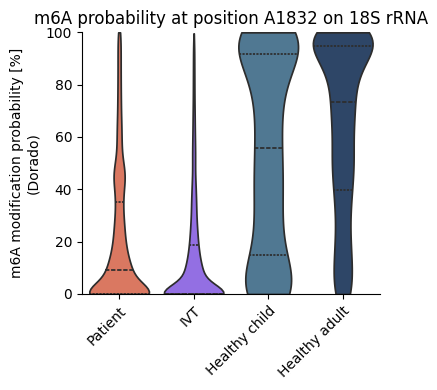

In [2]:
# PLOT RESULTS
input_colors = {"RNA002_blood" :"#cc78bc", "IVT" :"#029e73"}
input_colors = {"IVT" :"#8B5CF6", "Patient" :"#EE6C4D", "Healthy child" : "#457b9dff", "Healthy adult" : "#254470ff"}
plt.figure(figsize=(4, 4))
d_out["prob_perc"] = d_out["Mod_prob"]* 100
ax = sns.violinplot(x='Sample', y='prob_perc', inner = "quartile", palette=input_colors, hue = "Sample", data=d_out, order = ["Patient", "IVT", "Healthy child", "Healthy adult"], cut = 0)

ax.set_ylabel("m6A modification probability [%]\n(Dorado)")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0 , 100)
plt.title('m6A probability at position A1832 on 18S rRNA')
plt.tight_layout()

#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE6/PAPER_FIGURE_6E_prob.pdf", dpi = 300, bbox_inches='tight', transparent = True)
#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE6/PAPER_FIGURE_6E_prob.png", dpi = 300, bbox_inches='tight', transparent = True)

In [3]:
d_out['Sample'] = pd.Categorical(d_out['Sample'], categories=["Patient", "IVT", "Healthy child", "Healthy adult"], ordered=True)
grouped = d_out.groupby('Sample')['Mod_prob']

In [4]:
match_percentage = grouped.apply(lambda x: (x >= 0.98).sum() / len(x) * 100).reset_index(name = "m6A_freq")  # Red
num_reads = grouped.size().reset_index(name = "num_reads")  # 
new_df = pd.merge(match_percentage, num_reads)
#new_df.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_METTL5_freq.tsv", sep = "\t", index = False)

In [ ]:
d_out.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_METTL5_raw.tsv", sep = "\t", index = False)

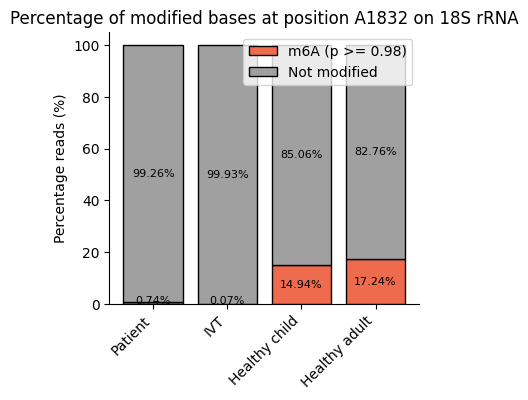

In [5]:
match_percentage = grouped.apply(lambda x: (x >= 0.98).sum() / len(x) * 100)  # Red
zero_percentage = grouped.apply(lambda x: (x < 0.98).sum() / len(x) * 100)  # Green
#non_match_percentage = 100 - match_percentage - zero_percentage  # Blue (remaining)


# Plot
fig, ax = plt.subplots(figsize=(4, 4))

bars1 = ax.bar(match_percentage.index, match_percentage,edgecolor='black', color='#ee6c4d', label='m6A (p >= 0.98)')
#bars2 = ax.bar(non_match_percentage.index, non_match_percentage,edgecolor='white', bottom=match_percentage, color='#0b3954', label='Failed (p < 0.98)')
bars3 = ax.bar(zero_percentage.index, zero_percentage, edgecolor='black',
       bottom=match_percentage,color='#a0a0a0', label='Not modified')


for bars in [bars1, bars3]:  # Loop through all bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero values
              if height < 1:
                     ax.text(bar.get_x() + bar.get_width()/2,  # X position (center of bar)
                            bar.get_y() + 1.2,  # Y position (middle of bar)
                            f'{height:.2f}%',  # Text (rounded percentage)
                            ha='center', va='center', fontsize=8, color='black')
              else:      
                     ax.text(bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
                            bar.get_y() + height / 2,  # Y position (middle of bar)
                            f'{height:.2f}%',  # Text (rounded percentage)
                            ha='center', va='center', fontsize=8, color='black')



# Labels & Formatting
ax.set_ylabel('Percentage reads (%)', color = "black")
ax.set_title('Percentage of modified bases at position A1832 on 18S rRNA', color = "black")
ax.legend(loc = 1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, color = "black",ha='right')
#plt.yticks(color = "white")

fig.patch.set_alpha(0.0) 
plt.subplots_adjust(bottom=0.2)
#plt.show()
#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE6/PAPER_FIGURE_6E_new_black.png", bbox_inches='tight', transparent=True, dpi=300)
#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE6/PAPER_FIGURE_6E_new_black.pdf", bbox_inches='tight', transparent=True, dpi=300)

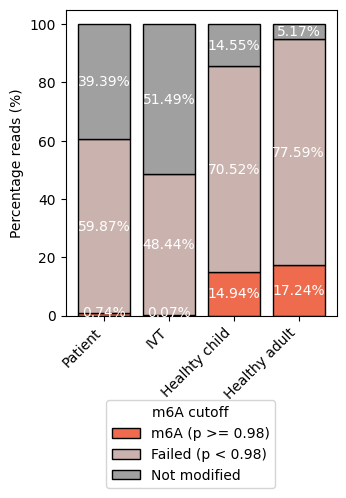

In [6]:
match_percentage = grouped.apply(lambda x: (x >= 0.98).sum() / len(x) * 100)  # Red
zero_percentage = grouped.apply(lambda x: (x == 0).sum() / len(x) * 100)  # Green
non_match_percentage = 100 - match_percentage - zero_percentage  # Blue (remaining)


# Plot
fig, ax = plt.subplots(figsize=(3.5, 4.5))

bars1 = ax.bar(match_percentage.index, match_percentage,edgecolor='black', color='#ee6c4d', label='m6A (p >= 0.98)')
bars2 = ax.bar(non_match_percentage.index, non_match_percentage,edgecolor='black', bottom=match_percentage, color="#cab3ae", label='Failed (p < 0.98)')
bars3 = ax.bar(zero_percentage.index, zero_percentage, edgecolor='black',
       bottom=match_percentage + non_match_percentage, color='#a0a0a0', label='Not modified')


for bars in [bars1, bars2, bars3]:  # Loop through all bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero values
              if height < 1:
                     ax.text(bar.get_x() + bar.get_width()/2,  # X position (center of bar)
                            bar.get_y() + 1.2,  # Y position (middle of bar)
                            f'{height:.2f}%',  # Text (rounded percentage)
                            ha='center', va='center', fontsize=10, color='white')
              else:      
                     ax.text(bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
                            bar.get_y() + height / 2,  # Y position (middle of bar)
                            f'{height:.2f}%',  # Text (rounded percentage)
                            ha='center', va='center', fontsize=10, color='white')



# Labels & Formatting
ax.set_ylabel('Percentage reads (%)')
#ax.set_title('Percentage of modified bases at position A1832 on 18S rRNA')
plt.legend(
    title="m6A cutoff",
    loc="center left",
    bbox_to_anchor=(0.15, -0.42),
    borderaxespad=0
)
plt.xticks(ticks = [0,1,2,3], labels = ["Patient", "IVT", "Healhty child", "Healthy adult"], rotation=45, color = "black", ha='right')
fig.patch.set_alpha(0.0) 
plt.subplots_adjust(bottom=0.2)
#plt.show()
#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/PAPER_FIGURE_6E_new_black.png", bbox_inches='tight', transparent=True, dpi=300)
#plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/PAPER_FIGURE_6E_new_black.pdf", bbox_inches='tight', transparent=True, dpi=300)